   # Double/Debiased Machine Learning

Author: [Anthony Strittmatter](https://www.anthonystrittmatter.com/)

The Job Corps is the largest U.S. labor market program targeting disadvantaged youths. It  provides  academic, vocational, and  social training, as well as health care counseling and job search assistance, for an average duration of eight to nine months. Mathematica Policy Research carried out a randomized experiment with the Job Corps. About 60% of the experimental participants were randomly selected to receive an offer to participatein the Job Corps. Out of these, 73% joined the Job Corps program and actually started to participate after an average duration of 1.4 months. The remaining experimental 
participants were assigned to the control group. Control group members were not eligible for the Job Corps programs for three years following randomization (approximately 1% participated anyway).

We estimate the effects of actually participating in the Job Corps on earnings fours years after the randomization. The experimental Job Corps data job_corps.csv contains 10'516 observations.

**Variable list :** 

* **EARNY4**: Earnings per week in Year 4
* **assignment**: Dummy for randomized offer to join Job Corps
* **participation**: Dummy for actual participation in Job Corps
* **female**: Dummy for females
* **age1**: Aged between 16-17 years
* **age2**: Aged between 18-19 years
* **age3**: Aged between 20-24 years
* **ed_06**: 0-6 months education program in last year prior experiment
* **ed_612**: 6-12 months education program in last year pror experiment
* **hs_ged**: High school or GED credential (general educational development test)
* **white**: Dummy for white ethnicity
* **black**: Dummy for African-American ethnicity
* **hisp**: Dummy for Hispanic ethnicity
* **oth_eth**: Dummy for other ethnicity
* **haschld**: Dummy for parents
* **livespou**: Lives with spouse or partner
* **everwork**: Ever had job for two weeks or more
* **yr_work**: Worked in year prior to random assignment
* **currjob**: Has job at random assignment
* **job0_3**: Below 3 months employed in last year
* **job3_9**: 3-9 months employed in last year
* **job9_12**: 9-12 months employed in last year
* **earn1**: Yearly earnings less than \$1'000 prior experiment 
* **earn2**: Yearly earnings \$1'000-5'000 prior experiment 
* **earn3**: Yearly earnings \$5'000-10'000 prior experiment 
* **earn4**: Yearly earnings above \$10'000 prior experiment 
* **badhlth**: Dummy for bad health
* **welf_kid**: Family on welfare when growing up
* **got_fs**: Received food stamps in last year
* **publich**: Public or rent-subsidized housing
* **got_afdc**: Received AFDC (aid for families with dependent children) in last year
* **harduse**: Used hard drugs in last year
* **potuse**: Smoked marijuana in last year
* **evarrst**: Ever arrested dummy
* **pmsa**: Lives in PMSA (primary metropolitan statistical area)
* **msa**: Lives in MSA (metropolitan statistical area)

Load the data "job_corps.csv". If not already installed, install the packages *grf*, *glmnet*, *tidyverse*, *DiagrammeR*, *lmtest*, *sandwich*, and *fBasics*.

Draw a random subsample of 3'000 observations. We need a smaller data set in this tutorial, because otherwise the computation time on the server would be too long. In reality you would use the entire data.
 

# Load Packages and the Data

In [19]:
##############################################################################
########################  Load Packages and the Data  ########################
##############################################################################

### Load the packages  
library(fBasics)     # use for descriptive statistics
library(tidyverse)   # use for handling data
library(DiagrammeR)  # use for plotting trees
library(lmtest)      # use for heteroscedasticity robust standard errors
library(sandwich)    # use for heteroscedasticity robust standard errors
library(grf)         # use for generalized random forest
library(glmnet)      # use for lasso and Elastic Net regularized Generalized Linear Models
options(warn=-1)     # supress warnings

print('All packages successfully installed and loaded.')

### Load the Data
set.seed(12345678) 
df <- read.csv("job_corps.csv",header=TRUE, sep=",") # load data from csv-file
df <- df[sample(c(1:nrow(df)), size=3000, replace =F),] # Select a random subsample of 3000 observations
print('Data successfully loaded.')

##############################################################################

[1] "All packages successfully installed and loaded."
[1] "Data successfully loaded."


# Descriptive Statistics

In [2]:
##############################################################################
########################  Descriptive Statistics  ############################
##############################################################################

## Table with Descriptive Statistics 
desc <- fBasics::basicStats(df) %>% t() %>% as.data.frame() %>% 
          select(Mean, Stdev, Minimum, Maximum, nobs)
print(round(desc, digits=2))

##############################################################################

                Mean  Stdev Minimum Maximum nobs
EARNY4        207.42 205.42       0 2357.74 3000
assignment      0.60   0.49       0    1.00 3000
participation   0.44   0.50       0    1.00 3000
female          0.43   0.49       0    1.00 3000
age_1           0.41   0.49       0    1.00 3000
age_2           0.32   0.46       0    1.00 3000
age_3           0.28   0.45       0    1.00 3000
ed0_6           0.26   0.44       0    1.00 3000
ed6_12          0.37   0.48       0    1.00 3000
hs_ged          0.25   0.43       0    1.00 3000
white           0.26   0.44       0    1.00 3000
black           0.49   0.50       0    1.00 3000
hisp            0.17   0.38       0    1.00 3000
oth_eth         0.07   0.26       0    1.00 3000
haschld         0.21   0.40       0    1.00 3000
livespou        0.07   0.25       0    1.00 3000
everwork        0.80   0.40       0    1.00 3000
yr_work         0.64   0.48       0    1.00 3000
currjob         0.20   0.40       0    1.00 3000
job0_3          0.22

# Double/Debiased Machine Learning

The goal is to estimate the effect of actual participation in Job Corps on earnings using the double/debiased machine learning approach ([Chernozhukov et al., 2017](https://www.aeaweb.org/articles?id=10.1257/aer.p20171038)). In contrast to the post-double-selection procedure, the double/debiased machine learning approach (1) allows for heterogeneous treatment effects, (2) is generic in the sense that it can be combined with any supervised machine learning method (and is not tailored to the Lasso), and (3) imposes no homogeneous effects on the characteristics $X$.

We make three identifying assumptions:

1. Stable Unit Treatment Value Assumption (SUTVA).
2. Conditional Mean Independence: $E[Y^d|D=1,X=x]=E[Y^d|D=0,X=x]$ for all values of $x$.
3. Common Support: $0< p(x) < 1$ for all values of $x$.

We are interested in three parameters:

- the ATE $\delta = E[Y^1-Y^0]$,
- the ATET $\rho = E[Y^1-Y^0|D=1]$, and
- the CATE $\delta(x) = E[Y^1-Y^0|X=x]$.

The ATE score is
\begin{equation*}
\tilde{Y}_{ATE}^* = \tilde{\mu}_1(X) - \tilde{\mu}_0(X) + \frac{D(Y-\tilde{\mu}_1(X))}{\tilde{p}(X)} -\frac{(1-D)(Y-\tilde{\mu}_0(X))}{1-\tilde{p}(X)}
\end{equation*}
where the nuisance parameters are $\tilde{\mu}_d(X)=\tilde{E}[Y^d|X]\stackrel{CIA}{=}\tilde{E}[Y|D=d,X]$ and $\tilde{p}(X)=\tilde{Pr}(D=1|X)$ (the latter is called the propensity score).

The ATET score is
\begin{equation*}
\tilde{Y}_{ATET}^* = \frac{D(Y-\tilde{\mu}_0(X))}{\tilde{p}} -\frac{(1-D)\tilde{p}(X)(Y-\tilde{\mu}_0(X))}{\tilde{p}(1-\tilde{p}(X))}
\end{equation*}
where $\tilde{p}=\tilde{Pr}(D=1)$ is the unconditional treatment probability.

The estimated parameters are:
- ATE: $\hat{\delta} = \hat{E}[\tilde{Y}_{ATE}^*]$,
- ATET: $\hat{\rho} = \hat{E}[\tilde{Y}_{ATET}^*]$,
- CATE: $\hat{\delta}(x) = \hat{E} [\tilde{Y}_{ATE}^*|X=x]$.

The double/debiased machine learning approach is $\sqrt{N}$-consistent if the nuisance parameters converge at rate $\sqrt[4]{N}$ and are estimated in an independent sample. The latter is required to avoid overfitting. In practice, we can use a cross-fitting procedure for sample splitting. We partition the sample into strata A and B of equal size. We estimate the nuisance parameters in sample A and the parameters of interest ($\hat{\delta}$, $\hat{\rho}$, and $\hat{\delta}(x)$) in sample B. Afterwards we switch samples A and B and repeat the estimation procedure. Finally, we report the average effects across both samples.

# Sample Splitting

In [3]:
###############################################################################
######################### Sample Splitting ####################################
###############################################################################

# Set starting value 
set.seed(123456789)

# Partition Samples for Cross-Fitting
df_part <- modelr::resample_partition(df, c(obs_A = 0.5, obs_B = 0.5)) # Split sample in strata of equal size
df_obs_A <- as.data.frame(df_part$obs_A) # Sample A
df_obs_B <- as.data.frame(df_part$obs_B) # Sample B

##  Generate Variables  
# Outcome variable
earnings_obs_A <- as.matrix(df_obs_A[,1])
earnings_obs_B <- as.matrix(df_obs_B[,1])

# Treatment variable
treat = 3 #Select treatment 2= offer to participate, 3 = actual participation
treat_obs_A <- as.matrix(df_obs_A[,treat])
treat_obs_B <- as.matrix(df_obs_B[,treat])

# Covariates
covariates_obs_A <- as.matrix(df_obs_A[,c(4:ncol(df_obs_A))])
covariates_obs_B <- as.matrix(df_obs_B[,c(4:ncol(df_obs_B))])

print('Sample partitioning ready.')

##############################################################################

[1] "Sample partitioning ready."


# Estimation of Nuisance Parameters with Lasso

### Potential Earning Under Non-Participation

In the sample of non-participants, we observe the potential earnings under non-participation, $Y^0$. Accordingly, we can estimate the conditional expectation of the potential earnings under non-participation in the sample of non-participants and extrapolate the fitted values to the entire sample (particpants and non-participants).

Below we use a cross-fitting procedure, such that the fitted values of each observation originate from an out-of-sample prediction.

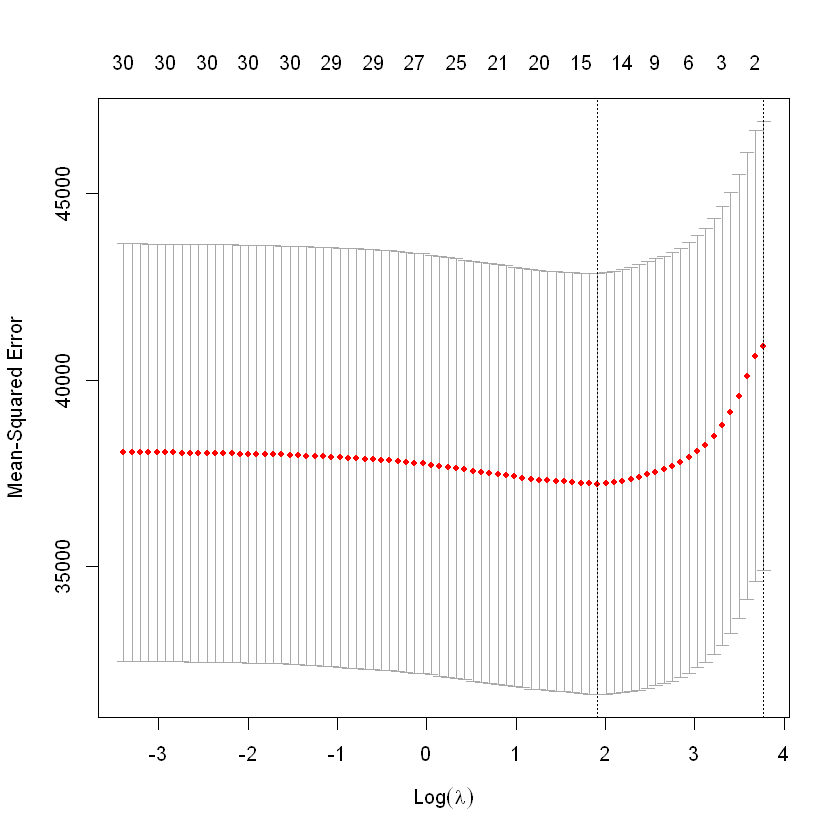

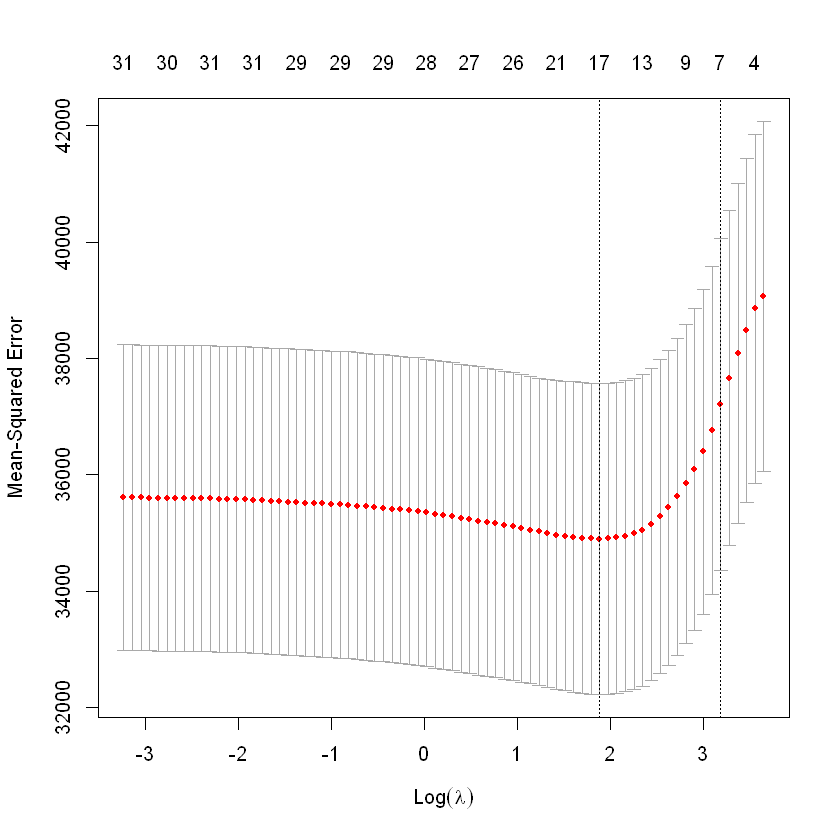

In [4]:
###############################################################################
########### Conditional Potential Earnings under Non-Participation ############
###############################################################################

p = 1 # 1 for LASSO, 0 for Ridge

# Set starting value
set.seed(123456789)

# Estimate Lasso among non-participants in Sample A
# Use cross-validation to select optimal lambda value
lasso_y0_A <- cv.glmnet(covariates_obs_A[treat_obs_A==0,], earnings_obs_A[treat_obs_A==0,],
                              alpha=p, type.measure = 'mse')
# Plot the cross-validated MSE
plot(lasso_y0_A)

# Extrapolate the fitted values to Sample B
y0hat_B <- predict(lasso_y0_A, newx = covariates_obs_B, type = 'response', s = lasso_y0_A$lambda.min)

# Estimate Lasso among non-participants in Sample B
lasso_y0_B <- cv.glmnet(covariates_obs_B[treat_obs_B==0,], earnings_obs_B[treat_obs_B==0,],
                              alpha=p, type.measure = 'mse')
# Plot the cross-validated MSE
plot(lasso_y0_B) 

# Extrapolate the fitted values to Sample A
y0hat_A <- predict(lasso_y0_B, newx = covariates_obs_A, type = 'response', s= lasso_y0_B$lambda.min)

# Merge fitted values of both samples
y0hat <- rbind(y0hat_A,y0hat_B)

#################################################################################

### Potential Earning Under Participation

In the sample of participants, we observe the potential earnings under participation, $Y^1$. Accordingly, we can estimate the conditional expectation of the potential earnings under participation in the sample of participants and extrapolate the fitted values to the entire sample (particpants and non-participants). We use the cross-fitting procedure as before.

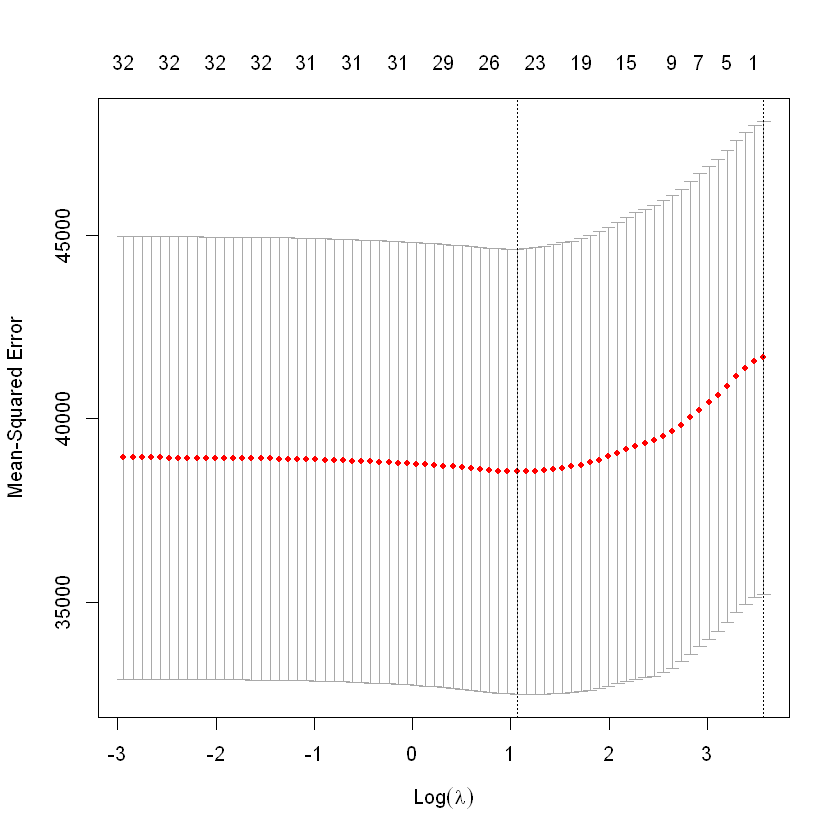

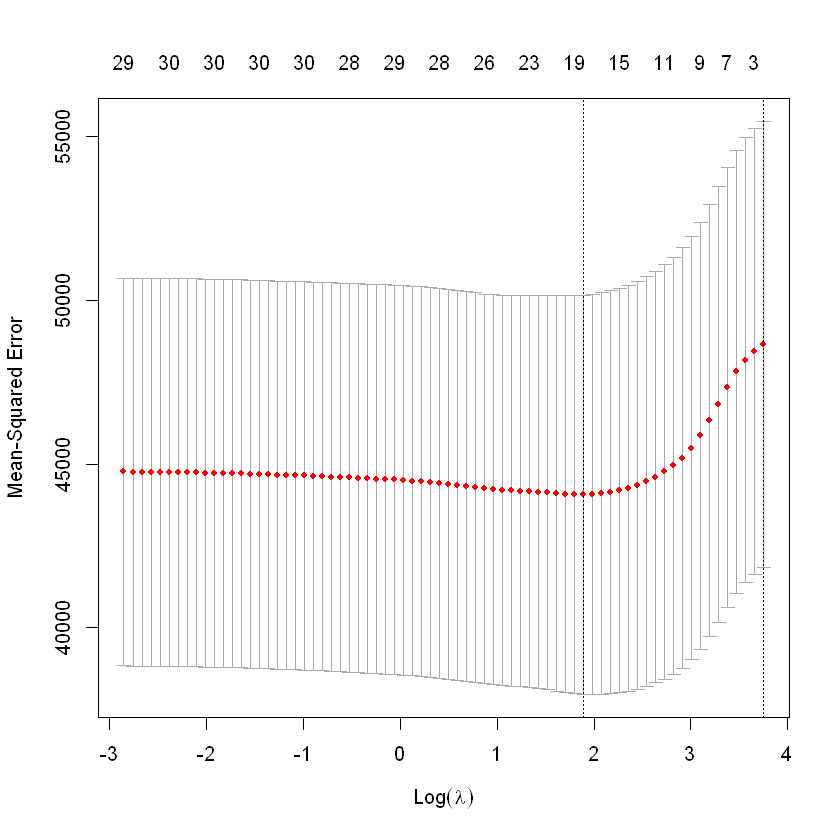

In [5]:
###############################################################################
########### Conditional Potential Earnings under Participation ############
###############################################################################

p = 1 # 1 for LASSO, 0 for Ridge

# Set starting value
set.seed(123456789)

# Estimate Lasso among participants in Sample A
# Use cross-validation to select optimal lambda value
lasso_y1_A <- cv.glmnet(covariates_obs_A[treat_obs_A==1,], earnings_obs_A[treat_obs_A==1,],
                              alpha=p, type.measure = 'mse')
plot(lasso_y1_A)

# Extrapolate the fitted values to Sample B
y1hat_B <- predict(lasso_y1_A, newx = covariates_obs_B, type = 'response', s = lasso_y1_A$lambda.min)

# Estimate Lasso among participants in Sample B
lasso_y1_B <- cv.glmnet(covariates_obs_B[treat_obs_B==1,], earnings_obs_B[treat_obs_B==1,],
                              alpha=p, type.measure = 'mse')
plot(lasso_y1_B)

# Extrapolate the fitted values to Sample A
y1hat_A <- predict(lasso_y1_B, newx = covariates_obs_A, type = 'response', s= lasso_y1_B$lambda.min)

# Merge the fitted values of both samples
y1hat <- rbind(y1hat_A,y1hat_B)

#################################################################################

## Propensity Score

The participation is a binary variable. Accordingly, we use a Logit-Lasso model to predict the proensity score. We se the cross-fitting procedure as described above.

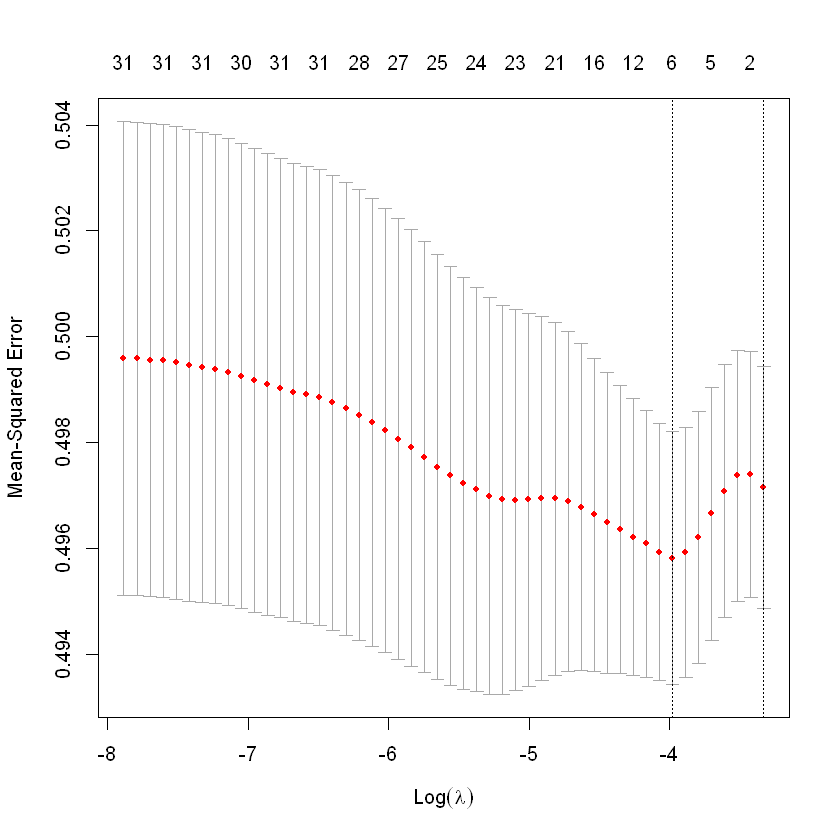

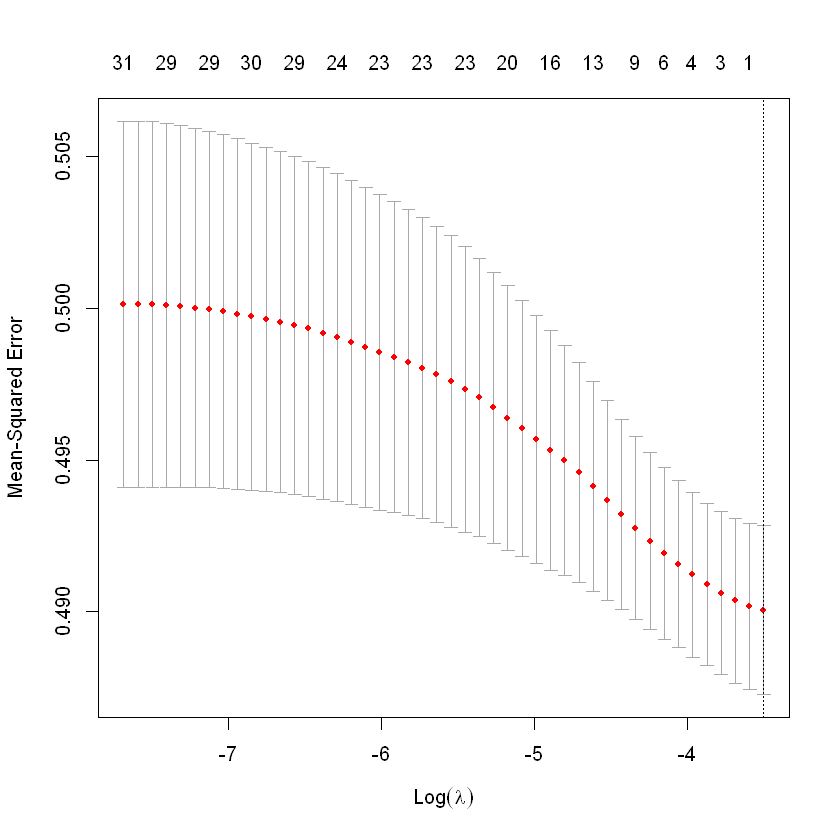

In [20]:
###############################################################################
########################### Propensity Score ##################################
###############################################################################

#  Propensity Score  
p = 1 # 1 for LASSO, 0 for Ridge

# Set starting value
set.seed(123456789)

# Estimate Logit-Lasso in Sample A
# Use cross-validation to select optimal lambda value
lasso_p_A <- cv.glmnet(covariates_obs_A, treat_obs_A, alpha=p, type.measure = 'mse', family="binomial")
plot(lasso_p_A)

# Extrapolate the fitted values to Sample B
pscore_B <- predict(lasso_p_A, newx = covariates_obs_B, type = 'response', s= lasso_p_A$lambda.min)

# Estimate Logit-Lasso in Sample B
lasso_p_B <- cv.glmnet(covariates_obs_B, treat_obs_B, alpha=p, type.measure = 'mse', family="binomial")
plot(lasso_p_B)

# Extrapolate the fitted values to Sample A
pscore_A <- predict(lasso_p_B, newx = covariates_obs_A, type = 'response', s= lasso_p_B$lambda.min)

# Merge the fitted values of both samples
pscore <- rbind(pscore_A,pscore_B)

###############################################################################

## Double Robust Score

Now we have all the ingredients we need to calculate the ATE and ATET scores and the corresponding parameters of interest.

### Calculate the ATE

We calculate the ATE score. We can use this score to estimate the ATE.

**Exercise:** Replace the *???* below.

In [7]:
###############################################################################
################################### ATE Score #################################
###############################################################################

# Merge earnings outcome of Sample A and B
earnings_obs <- rbind(earnings_obs_A,earnings_obs_B)

# Merge treatmente of Sample A and B
treat_obs <- rbind(treat_obs_A,treat_obs_B)

# Calculate the ATE score using the formula described above
Y_ate_star = invisible(???)

# Calculate ATE
# It is the sample average of the ATE score
ate <- round(mean(Y_ate_star), digits = 2)

# Calculate the standard errors of the ATE
# Square root of the quotient of variance of the ATE score and the sample size
se_ate <- round(sqrt(var(Y_ate_star)/length(Y_ate_star)), digits = 2)


print(paste0("Average Treatment Effect (ATE): ", ate))
print(paste0("Standard Error for ATE: ", se_ate))

###############################################################################

[1] "Average Treatment Effect (ATE): 20.51"
[1] "Standard Error for ATE: 7.26"


If all individuals of the sample would have participated in Job Corps, earnings would have increased on average by 20.51 Dollars. The effect is statistically significant.

### Calculate the ATET

We calculate the ATET score. We can use this score to estimate the ATET.

**Exercise:** Replace the *???* below.

In [8]:
###############################################################################
################################## ATET Score #################################
###############################################################################

## Unconditional Treatment probability
p = mean(pscore)

# Calculate the ATET score using the formula described above
Y_atet_star = invisible(???)

# Calculate ATET
# It is the sample average of the ATET score
atet <- round(mean(Y_atet_star), digits = 2)

# Calculate the standard errors of the ATET
# Square root of the quotient of variance of the ATET score and the sample size
se_atet <- round(sqrt(var(Y_atet_star)/length(Y_atet_star)), digits = 2)

print(paste0("Average Treatment Effect for Treated (ATET): ", atet))
print(paste0("Standard Error for ATET: ", se_atet))

###############################################################################

[1] "Average Treatment Effect for Treated (ATET): 20.84"
[1] "Standard Error for ATET: 7.25"


The effect of participation in Job Corps on weekls earnings four years after the experiment is 20.84 for an average participant. The effect is statistically significant.

## CATEs

We use the approach of [Semenova and Chernozhukov (2020)](https://academic.oup.com/ectj/advance-article-abstract/doi/10.1093/ectj/utaa027/5899048) to estimate the CATEs. They propose to run a simple linear regression on the ATE score. The resulting coefficients of the OLS regression are consistent and the standard errors asymptotically valid.

In [9]:
###############################################################################
##################################### CATEs ###################################
###############################################################################

# Merge covariates of Sample A and B
covariates_obs <- rbind(covariates_obs_A,covariates_obs_B)

# Generate a new data frame
# Merge the ATE score and the covariates
colnames(Y_ate_star) <- "y_star"
Y_star <- as.data.frame(cbind(Y_ate_star,covariates_obs[,-c(3,8)]))

# Estimate an OLS regression
# Regress the ATE score on the covariates
cates <- lm(y_star ~., Y_star)

# Heteroskedasticity robust standard errors
coeftest(cates, vcov = vcovHC(cates, type = "HC1"))

###############################################################################


t test of coefficients:

             Estimate Std. Error t value Pr(>|t|)  
(Intercept) -22.26946   31.31267 -0.7112  0.47702  
female       -8.93871   15.58388 -0.5736  0.56629  
age_1        14.90832   19.34097  0.7708  0.44088  
age_3        11.82209   21.07211  0.5610  0.57482  
ed0_6        16.05881   19.21604  0.8357  0.40339  
ed6_12       18.62722   19.16156  0.9721  0.33107  
hs_ged       -5.75557   19.11756 -0.3011  0.76339  
black        34.16762   20.17674  1.6934  0.09048 .
hisp          7.26422   25.35105  0.2865  0.77448  
oth_eth     -15.16619   31.25218 -0.4853  0.62751  
haschld       0.71098   21.49903  0.0331  0.97362  
livespou      0.22304   27.14986  0.0082  0.99345  
everwork     10.16258   22.76965  0.4463  0.65540  
yr_work      54.16046   58.85853  0.9202  0.35755  
currjob       2.47973   23.21004  0.1068  0.91492  
job0_3      -22.87297   33.60450 -0.6807  0.49614  
job3_9      -15.65457   30.41565 -0.5147  0.60681  
job9_12     -15.68711   32.85226 -0.47

We find for several variables relatively large coefficients. However, only the coefficients of the variables *black* and *msa* are statistically significant. Possibly, more coefficients are significant when we use a larger sample.

We find that the effect of Job Corps participation on earnings is 34.18 Dollars larger for Afro-Americans than for white. Furthermore, participation in Job Corps has a 44.23 Dollar larger earnings effect for individuals living in urban (*MSA*) rather than rural areas.

Next, we calculate the number of individuals with positive and negative predicted earnings effects.

In [10]:
###############################################################################

# Calculate the predicted effect size for each observation
fit <- predict(cates)

# Count the observations with positive and negative effects
print(paste0("Number of individuals with positive effects: ", length(fit[fit>=0])))
print(paste0("Number of individuals with negative effects: ", length(fit[fit<0])))

###############################################################################

[1] "Number of individuals with positive effects: 2105"
[1] "Number of individuals with negative effects: 895"


Participation in Job Corps has a negative earnings effect for 30\% of the sample. These individuals should not participate. It would be a waste of ressources.

We plot the cumulative distribution of the predicted CATEs.

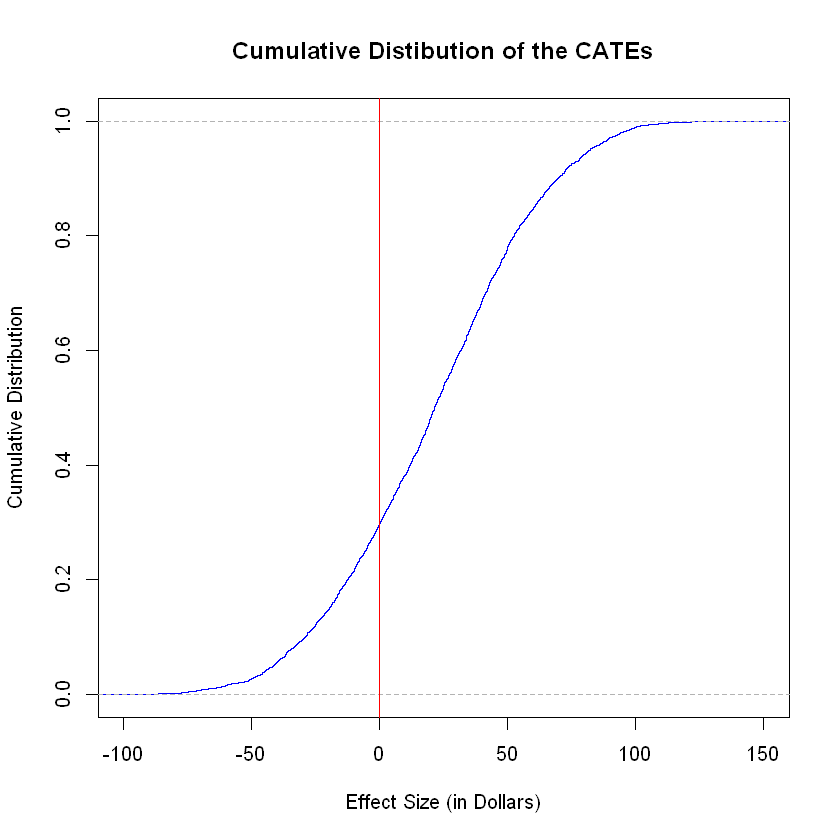

In [11]:
###############################################################################
################ Plot Cumulative Distribution of CATEs ########################
###############################################################################

plot(ecdf(fit), col="blue", xlim = c(-100,150), xlab="Effect Size (in Dollars)",
     ylab="Cumulative Distribution", main="Cumulative Distibution of the CATEs")
abline(v=0, col="red")

###############################################################################

Again we see that the participation effect is negative for 30\% of the sample.

Finally, we investigate the mean characteristics of those individuals with positive and negative effects.

In [12]:
###############################################################################
######################## Description of CATEs #################################
###############################################################################

## Means and standard deviations for individuals with positive effects
desc_1 <- fBasics::basicStats(Y_star[fit >= 0,-1]) %>% t() %>% as.data.frame() %>% select(Mean, Stdev)

## Means and standard deviations for individuals with negative effects
desc_0 <- fBasics::basicStats(Y_star[fit < 0,-1]) %>% t() %>% as.data.frame() %>% select(Mean, Stdev)

# Make table and add standardized differences
desc <- cbind(desc_1,desc_0, 
        100*abs(desc_1[,1]-desc_0[,1])/sqrt(0.5*(desc_1[,2]^2+desc_0[,2]^2)))
colnames(desc) <- c("Mean (Pos.)", "Std.Dev. (Pos.)", "Mean (Neg.)", "Std.Dev. (Neg.)", "Std.Diff.")
print(round(desc, digits=2))

###############################################################################

         Mean (Pos.) Std.Dev. (Pos.) Mean (Neg.) Std.Dev. (Neg.) Std.Diff.
female          0.41            0.49        0.47            0.50     11.32
age_1           0.46            0.50        0.28            0.45     36.44
age_3           0.27            0.44        0.31            0.46     10.31
ed0_6           0.28            0.45        0.21            0.41     15.74
ed6_12          0.40            0.49        0.28            0.45     26.97
hs_ged          0.23            0.42        0.31            0.46     17.26
black           0.60            0.49        0.22            0.41     84.70
hisp            0.14            0.35        0.25            0.43     26.71
oth_eth         0.03            0.18        0.16            0.37     44.54
haschld         0.21            0.41        0.19            0.39      5.82
livespou        0.06            0.23        0.09            0.29     14.59
everwork        0.79            0.41        0.82            0.38      8.82
yr_work         0.62     

The standardized differences ($SD$) are defined as

$SD = 100 \displaystyle \cdot \frac{|\bar{X}_1 - \bar{X}_0|}{\sqrt{1/2 \cdot (\sigma_{X1}^2+\sigma_{X0}^2)}}$

where $\bar{X}_1$ and $\bar{X}_0$ are the means and $\sigma_{X1}$ and $\sigma_{X0}$ the standard deviations in the groups of individuals with postive and negative CATEs, respectively. Large standardized differences indicate a large inbalance between the characteristics of individuals with postive and negative CATEs.

We find large differences between the groups with postive and negative effects. As expected, the standardized differences are largest for *black* and *msa*. But also the differences between other characteristics are relatively large. For example, only 3\% of individuals with positive predicted effects, but 12\% of individuals with negative predicted effects, useed hard drugs in the year before the experiment.

# Random Forest Approach

The double/debiased machine learning approach can use any supervised machine learning technique to estimate the nuisance parameters. In the following we use the generalized random forest of [Athey, Tibshirani, and Wager (2019)](https://projecteuclid.org/journals/annals-of-statistics/volume-47/issue-2/Generalized-random-forests/10.1214/18-AOS1709.full) to estimate the nuisance parameters for the ATET.

## Estimation of Nuisance Parameters with Random Forest

### Potential Outcome Under Non-Participation

In [13]:
###############################################################################
########### Conditional Potential Earnings under Non-Participation ############
###############################################################################

# Set starting value
set.seed(123456789)

# Tuning parameters for forest
trees = 1000 # number of trees in the forest
frac = 0.5 # share of subsample used for each tree
cov = floor(1/2*ncol(covariates_obs)) # number of covariates used for each tree
min = 10 # minimum sample size in the terminal leaves of the trees

# Estimate Random Forest among non-participants in Sample A
forest_y0_A <- regression_forest(covariates_obs_A[treat_obs_A==0,], earnings_obs_A[treat_obs_A==0,],
                              num.trees = trees, sample.fraction = frac, mtry = cov, min.node.size = min)

# Extrapolate the fitted values to Sample B
y0hat_B <- as.matrix(predict(forest_y0_A, newdata = covariates_obs_B)$predictions)

print("Random Forest for Sample A estimated.")

#################################################################################

[1] "Random Forest for Sample A estimated."


In [14]:
#################################################################################

# Plot one tree from the random forest
plot(tree <- get_tree(forest_y0_A, 1))
# the last number is the tree number
# it can be varied from 1 to 1000

#################################################################################

HTML widgets cannot be represented in plain text (need html)

The tree is relatively complex and difficult to interpret. In particular, the forest is difficult to interpret, because it consists of 1000 trees.

As an alternative to plotting the tree, we can count the number of times each variable is used for tree splitting on each tree depth.

In [15]:
#################################################################################

# Count the splitting frequencies for each covariate
split <- split_frequencies(forest_y0_A, max.depth = 4)
# max.depth specifies the maximum tree depth we consider

# Label the results
colnames(split) <- colnames(covariates_obs)
rownames(split) <- c("Depth 1", "Depth 2", "Depth 3", "Depth 4")

print(t(split))

#################################################################################

         Depth 1 Depth 2 Depth 3 Depth 4
female       154     229     271     232
age_1          3      24      78     168
age_2          2      31     119     142
age_3         22      87     147     181
ed0_6          0      19      81     182
ed6_12         0      24     128     244
hs_ged        32     111     159     233
white         91     112     128     128
black        190     198     199     150
hisp          18      95      99     162
oth_eth        1      19      55      89
haschld        2      72     115     170
livespou       4      18      56     129
everwork      34      59      68     118
yr_work      175     151     115     124
currjob       33      76     117     172
job0_3         1      25      67     127
job3_9         1      22      74     128
job9_12       66      58      76     122
earn1          1       9      33      85
earn2          2      35      73     142
earn3         35      66     120     149
earn4         76      95      88     104
badhlth        1

We find that *female*, *black*, and *yr\_work* are relatively important variables for the random forest. However, interpreting the number of sample splits has also its limitations. For example, it is unclear how much the importance of splits decays with the tree depht. Overall, we can conclude that the random forest is a **black box** estimator.

For the purpose of cross-fitting, we have to estimate the random forest also in Sample B.

**Exercise:** Replace the *???* below.

In [16]:
#################################################################################

# Estimate Random Forest among non-participants in Sample B
forest_y0_B <- regression_forest(???)

# Extrapolate the fitted values to Sample A
y0hat_A <- as.matrix(predict(forest_y0_B, newdata = covariates_obs_A)$predictions)

# Merge fitted values of both samples
y0hat <- rbind(y0hat_A,y0hat_B)

print("Random Forest for Sample B estimated.")

#################################################################################

[1] "Random Forest for Sample B estimated."


### Propensity Score

We can calculate the propensity score also with random forests. Since the random forest is a non-parametric estimator, it takes account of the fact that the outcome (*participation*) is binary.

In [17]:
###############################################################################
########################### Propensity Score ##################################
###############################################################################

# Set starting value
set.seed(123456789)

# Tuning parameters for forest
trees = 1000
frac = 0.5
cov = floor(1/2*ncol(covariates_obs))
min = 10

# Estimate Random Forest in Sample A
forest_p_A <- regression_forest(covariates_obs_A, treat_obs_A, 
                         num.trees = trees, sample.fraction = frac, mtry = cov, min.node.size = min)

# Extrapolate the fitted values to Sample B
pscore_B <- as.matrix(predict(forest_p_A, newdata = covariates_obs_B)$predictions)

##############

# Estimate Random Forest in Sample B
forest_p_B <- regression_forest(covariates_obs_B, treat_obs_B, 
                         num.trees = trees, sample.fraction = frac, mtry = cov, min.node.size = min)

# Extrapolate the fitted values to Sample A
pscore_A <- as.matrix(predict(forest_p_B, newdata = covariates_obs_A)$predictions)

# Merge the fitted values of both samples
pscore <- rbind(pscore_A,pscore_B)

print("Propensity score is estimated.")

###############################################################################

[1] "Propensity score is estimated."


## Calculation of the ATET

We calculate the ATET score using the random forest nuisance parameters. Then we use this score to estimate the ATET.

In [18]:
###############################################################################
################################## ATET Score #################################
###############################################################################

## Unconditional Treatment probability
p = mean(pscore)

# Calculate the ATET score using the formula described above
Y_atet_star = invisible(treat_obs*(earnings_obs - y0hat)/p 
            - (1-treat_obs)*pscore*(earnings_obs - y0hat)/(p*(1-pscore)))

# Calculate ATET
# It is the sample average of the ATET score
atet <- round(mean(Y_atet_star), digits = 2)

# Calculate the standard errors of the ATET
# Square root of the quotient of variance of the ATET score and the sample size
se_atet <- round(sqrt(var(Y_atet_star)/length(Y_atet_star)), digits = 2)

print(paste0("Average Treatment Effect for Treated (ATET): ", atet))
print(paste0("Standard Error for ATET: ", se_atet))

###############################################################################

[1] "Average Treatment Effect for Treated (ATET): 20.34"
[1] "Standard Error for ATET: 7.2"


The average effect of participation on earnings is 20.34 Dollars for participants. The effect is statistically significant.

**Additional Exercises:**

- Change the *seed* for sample splitting. How do the selected Lasso models change? How do the Lasso estimates of the ATE and ATET change?
- Estimate the ATE and ATET using the Ridge to estimate the nuisance parameters.
- Estimate the ATEs and CATEs with the score that was estimated with the random forest. How do the results differ from the Lasso?